Deep learning w/ PyTorch

Robert Kesterson

Convolutional neural networks (CNNs) were all the rage at image classification challenges from about 2014 to 2017.
They were bested by recurrent convolutional neural networks (RNNs) from 2017 to 2020.

In 2017 a paper called "Attention is all you need" was published by Ashish Vaswani et. al which proposed the existence
of transformer architectures. Transformers set the world of ai / ml alight and have been responsible for a significant
amount of new developments in the field since 2020.

What follows below is a humble example of simple CNNs trained against the CIFAR10 data set with the goal of
arrurately classifying 50,000 images (32 x 32 pixels each with 3 color channels) into 10 categories.

The categories are:
airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck

In [1]:
import math

#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt              # For plotting
import seaborn as sns                        # For styling plots
import torch                                 # Overall PyTorch import
import torch.nn as nn                        # For specifying neural networks
import torch.nn.functional as F              # For common functions
import torch.optim as optim                  # For optimizizing model parameters
import torchvision.datasets as datasets      # To download data
import torchvision.transforms as transforms  # For pre-processing data

sns.set()

INPUT_SIZE = 3 * 32 * 32   # An image has 32 x 32 pixels each with Red/Green/Blue values.
NUM_CLASSES = 10            # The number of output classes. In this case, from 0 to 9
NUM_EPOCHS = 10            # The number of times we loop over the whole dataset during training
BATCH_SIZE = 100           # The size of input data took for one iteration of an epoch
LEARNING_RATE = 1e-3          # The speed of convergence

Begin by downloading and transforming the CIFAR10 data set.

In [2]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Define methods for training the CNNs, measuring their accuracy, and plotting their history

In [3]:
def train(net, train_loader, test_loader,
          num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
          compute_accs=False):
    """
    This function trains the given network on the training data for the given number of epochs.
    If compute_accs is true, evaluates the train and test accuracy of the network at the end of
    each epoch.

    Args:
        net: The neural network to train
        train_loader, test_loader: The pytorch dataset loaders for the trainst and testset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and test
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and test accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer
    # (algorithm like gradient descent). Here we use a common loss function for multi-class
    # classification called the Cross Entropy Loss and the popular Adam algorithm.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for images, labels in train_loader:   # Loop over each batch in train_loader

            # If you are using a GPU, speed up computation by moving values to the GPU
            if torch.cuda.is_available():
                net = net.cuda()
                images = images.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes

            if batch_num % 100 == 0:  # Print every 100 batches
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

            batch_num += 1


      # Compute the training and test accuracies and puts those values at the end of train_accs and test_accs
        if compute_accs:
            train_acc = accuracy(net, train_loader)
            test_acc = accuracy(net, test_loader)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print(f'Epoch [{epoch}/{num_epochs}], Train Accuracy {100 * train_acc:.2f}%, Test Accuracy {100 * test_acc:.2f}%')
    if compute_accs:
        return train_accs, test_accs
    else:
        return None


def accuracy(net, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:
        if  torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count

    return correct / total


def plot_history(histories):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained.
                   Each dictionary should have the keys:
                        * name: The model name
                        * train_accs: A list of train accuracies
                        * test_accs: A list of test accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      val = plt.plot(epochs, model_history['test_accs'], '--', label=model_history['name'] + ' Test')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(), label=model_history['name'] + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])
    plt.show()

Now we will define four simple neural networks of increasing complexity

Network A - Accepts an image flattens it into a vector, then attempts to classify using a single linear layer

Network B - Flattens the image, uses a fully-connected layer with 300 hidden neurons, utilizes relu activation, then a fully-connected linear layer to classify into the 10 output categories

Network C - A convolutional neural network containing a convolution layer with kernel-width 5 and depth 25, relu activation, a max-pooling layer with kernel-width 2 and stride 2, flattening, and finally a linear layer for output classification

Network D - The most complex of the set, but still a relatively simple CNN. This one features two sets of convolution, pooling, and dropout layers followed by relu activation. Following that the input is flattened, run through a linear layer, a dropoout layer, and one final instance of relu activation. The resulthing dropout layer is then fed into a final linear layer for classification. 

In [4]:
class NetA(nn.Module):

  def __init__(self):
    super(NetA, self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(INPUT_SIZE, NUM_CLASSES)

  def forward(self, x):
    x = self.flatten(x)
    x = self.fc1(x)
    return x

class NetB(nn.Module):

  def __init__(self):
    super(NetB, self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(INPUT_SIZE, 300)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(300, NUM_CLASSES)

  def forward(self, x):
    x = self.flatten(x)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

class NetC(nn.Module):

  def __init__(self):
    super(NetC, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=25, kernel_size=5)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten1 = nn.Flatten()
    self.fc1 = nn.Linear(4900, NUM_CLASSES)

  def forward(self, x):
    x = self.relu1(self.conv1(x))
    x = self.pool1(x)
    x = self.flatten1(x)
    x = self.fc1(x)
    return x

class NetD(nn.Module):

  def __init__(self):
    super(NetD, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=25, kernel_size=5)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.drop1 = nn.Dropout(p=0.05)
    self.relu1 = nn.ReLU()

    # out_channels = 125 kernel_size = 5 yields 42.1% test accuracy
    # out_channels = 110 yeilds 43.4% test accuracy
    self.conv2 = nn.Conv2d(in_channels=25, out_channels=110, kernel_size=5)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.drop2 = nn.Dropout(p=0.05)
    self.relu2 = nn.ReLU()

    self.flatten1 = nn.Flatten()

    self.fc1 = nn.Linear(2750, 1375)
    self.drop4 = nn.Dropout(p=0.2)
    self.relu4 = nn.ReLU()

    self.fc2 = nn.Linear(1375, NUM_CLASSES)

  def forward(self, x):
    x = self.relu1(self.drop1(self.pool1(self.conv1(x))))
    x = self.relu2(self.drop2(self.pool2(self.conv2(x))))
    x = self.flatten1(x)
    x = self.relu4(self.drop4(self.fc1(x)))
    x = self.fc2(x)
    return x

Finally, create instances of each network, train them, and compare the performance over 10 epochs.

Note - This code takes considerable time to run on a tablet. Full output with the plotted graph was normally ~3 - 4 hours in testing.

==== Training NetA ====
Epoch [1/10], Step [100/500], Loss: 1.8391
Epoch [1/10], Step [200/500], Loss: 1.9944
Epoch [1/10], Step [300/500], Loss: 1.8923
Epoch [1/10], Step [400/500], Loss: 1.8377
Epoch [1/10], Step [500/500], Loss: 1.8048
Epoch [1/10], Train Accuracy 39.88%, Test Accuracy 37.77%
Epoch [2/10], Step [100/500], Loss: 1.9060
Epoch [2/10], Step [200/500], Loss: 1.7499
Epoch [2/10], Step [300/500], Loss: 1.9495
Epoch [2/10], Step [400/500], Loss: 1.8199
Epoch [2/10], Step [500/500], Loss: 1.8246
Epoch [2/10], Train Accuracy 39.16%, Test Accuracy 37.46%
Epoch [3/10], Step [100/500], Loss: 1.5871
Epoch [3/10], Step [200/500], Loss: 1.6377
Epoch [3/10], Step [300/500], Loss: 1.6874
Epoch [3/10], Step [400/500], Loss: 1.9880
Epoch [3/10], Step [500/500], Loss: 1.5953
Epoch [3/10], Train Accuracy 40.02%, Test Accuracy 37.10%
Epoch [4/10], Step [100/500], Loss: 1.7946
Epoch [4/10], Step [200/500], Loss: 1.6651
Epoch [4/10], Step [300/500], Loss: 1.6748
Epoch [4/10], Step [400/500]

Epoch [10/10], Train Accuracy 73.95%, Test Accuracy 65.91%
==== Training NetD ====
Epoch [1/10], Step [100/500], Loss: 1.3902
Epoch [1/10], Step [200/500], Loss: 1.3236
Epoch [1/10], Step [300/500], Loss: 1.2530
Epoch [1/10], Step [400/500], Loss: 1.0827
Epoch [1/10], Step [500/500], Loss: 1.0282
Epoch [1/10], Train Accuracy 61.82%, Test Accuracy 59.51%
Epoch [2/10], Step [100/500], Loss: 1.2052
Epoch [2/10], Step [200/500], Loss: 1.1158
Epoch [2/10], Step [300/500], Loss: 0.9975
Epoch [2/10], Step [400/500], Loss: 0.8255
Epoch [2/10], Step [500/500], Loss: 1.2655
Epoch [2/10], Train Accuracy 69.95%, Test Accuracy 66.19%
Epoch [3/10], Step [100/500], Loss: 0.7570
Epoch [3/10], Step [200/500], Loss: 0.9269
Epoch [3/10], Step [300/500], Loss: 0.9456
Epoch [3/10], Step [400/500], Loss: 0.7064
Epoch [3/10], Step [500/500], Loss: 0.5441
Epoch [3/10], Train Accuracy 76.37%, Test Accuracy 68.66%
Epoch [4/10], Step [100/500], Loss: 0.4338
Epoch [4/10], Step [200/500], Loss: 0.4865
Epoch [4/10]

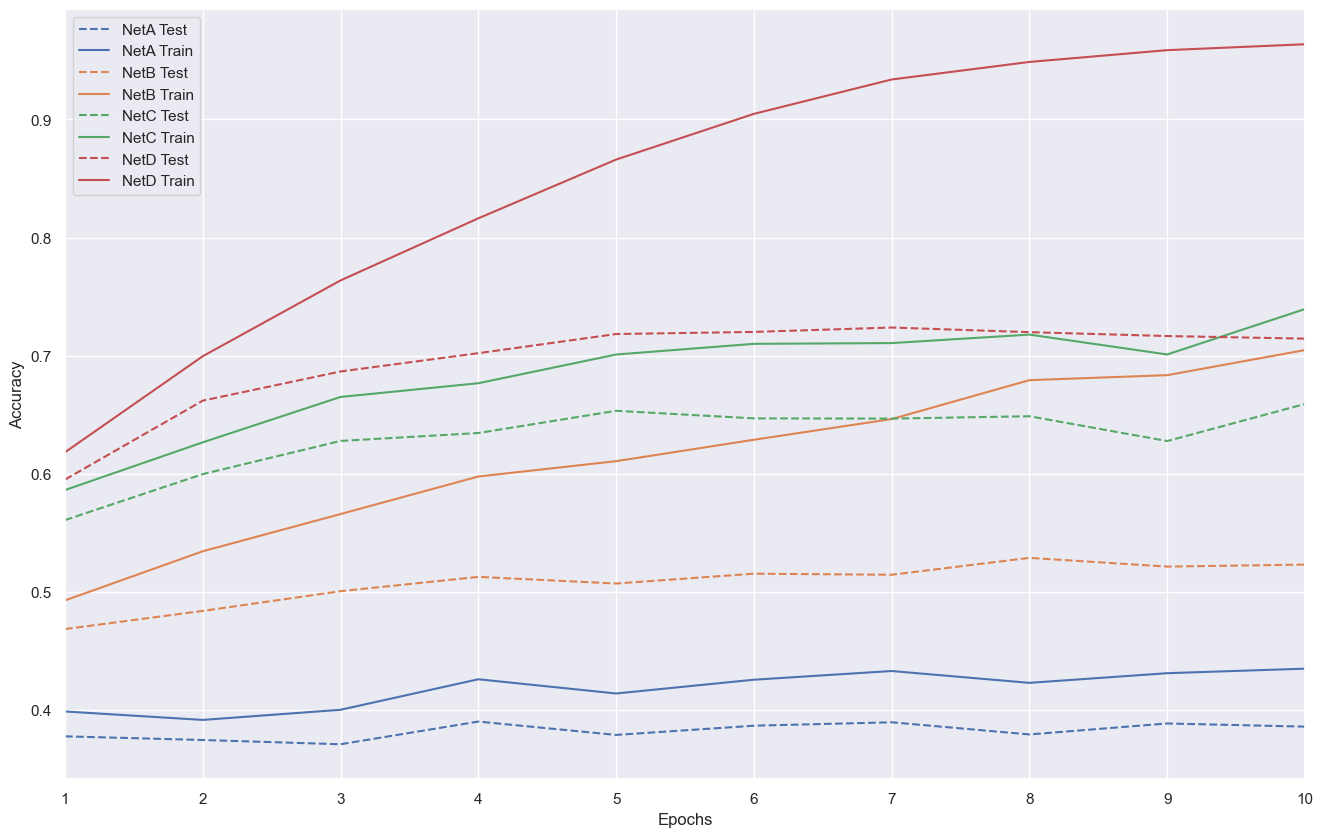

In [5]:
#%%time
nets = [NetA(), NetB(), NetC(), NetD()]
histories = []

for net in nets:
    net_name = type(net).__name__
    print(f'==== Training {net_name} ====')
    train_history, test_history = train(net, train_loader, test_loader,
                                        num_epochs=NUM_EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        compute_accs=True)
    histories.append({
        'name': net_name,
        'net': net,
        'train_accs': train_history,
        'test_accs': test_history
    })
plot_history(histories)